# Analysis of weighted vs non-weighted lcapture

In [79]:
from pathlib import Path

import geopandas as gpd
import pandas as pd
import xarray as xr
import numpy as np
import rioxarray
from sklearn.metrics import mean_absolute_error


data_dir = Path("../data")
plots_dir = data_dir / "outputs" / "plots"
metrics_dir = plots_dir / "metrics"
net_cdf_dir = metrics_dir / "x1-y1-z1" / "net_cdf"
cover_metrics_dir = metrics_dir / "cover_metrics"

cover_metrics_dir.mkdir(parents=True, exist_ok=True)

In [6]:
plots = gpd.read_file(plots_dir / "plots.geojson")
plots = plots.set_index("id")
plots

,site,plot_number,site_plot_id,geometry
id,,,,
AGG_O_01_P1,AGG_O_01,1,AGG_O_01_P1,"POLYGON ((463042.83 5259846.736, 463025.797 52..."
AGG_O_01_P2,AGG_O_01,2,AGG_O_01_P2,"POLYGON ((463124.556 5259819.234, 463116.068 5..."
AGG_O_01_P3,AGG_O_01,3,AGG_O_01_P3,"POLYGON ((463201.174 5259815.806, 463200.551 5..."
AGG_O_01_P4,AGG_O_01,4,AGG_O_01_P4,"POLYGON ((463257.777 5259801.962, 463245.303 5..."
AGG_O_01_P5,AGG_O_01,5,AGG_O_01_P5,"POLYGON ((463303.022 5259789.552, 463289.794 5..."
...,...,...,...,...
ULY_Y_96_P1,ULY_Y_96,1,ULY_Y_96_P1,"POLYGON ((455348.476 5275834.517, 455348.154 5..."
ULY_Y_96_P2,ULY_Y_96,2,ULY_Y_96_P2,"POLYGON ((455296.576 5275837.224, 455299.223 5..."
ULY_Y_96_P3,ULY_Y_96,3,ULY_Y_96_P3,"POLYGON ((455252.092 5275834.16, 455248.849 52..."


In [74]:
def read_metric_ds(plot_id: str):
    metric_ds = xr.open_dataset(net_cdf_dir / f"{plot_id}.nc")
    return metric_ds

def get_lcapture_methods(plot_id: str):
    ds = read_metric_ds(plot_id)
    count_1m_mean = ds['vox_lcapture'].mean(dim=['x', 'y'])
    weight_1m_mean = ds['vox_lcapture_weight'].mean(dim=['x', 'y'])

    count_fullgrain = ds['vox_inside_count'].sum(dim=['x', 'y']) / ds['vox_enter_count'].sum(dim=['x', 'y'])
    weight_fullgrain = ds['vox_inside_weight'].sum(dim=['x', 'y']) / ds['vox_enter_weight'].sum(dim=['x', 'y'])

    ds = xr.Dataset({
        'count_1m_mean': count_1m_mean * 100,
        'weight_1m_mean': weight_1m_mean * 100,
        'count_fullgrain': count_fullgrain * 100,
        'weight_fullgrain': weight_fullgrain * 100,
    })

    # # Remove ground level (z=0)
    # ds = ds.sel(z=slice(1, None))

    df =  ds.to_dataframe().reset_index()
    
    return df

In [75]:
results = []

for idx, row in plots.iterrows():
    df = get_lcapture_methods(idx)
    df['plot_id'] = idx
    results.append(df)

lcapture_metrics = pd.concat(results)
lcapture_metrics

,z,count_1m_mean,weight_1m_mean,count_fullgrain,weight_fullgrain,plot_id
0,0.0,100.000000,100.000000,100.000000,100.000000,AGG_O_01_P1
1,1.0,47.121386,47.601193,45.552402,45.232569,AGG_O_01_P1
2,2.0,6.187441,5.333589,6.282257,4.973427,AGG_O_01_P1
3,3.0,5.154575,4.182222,5.594758,4.170029,AGG_O_01_P1
4,4.0,5.754391,4.693265,6.566641,4.997845,AGG_O_01_P1
...,...,...,...,...,...,...
32,32.0,0.076810,0.048948,0.108833,0.064029,ULY_Y_96_P5
33,33.0,0.047344,0.028551,0.070004,0.042271,ULY_Y_96_P5
34,34.0,0.012990,0.008511,0.029993,0.020137,ULY_Y_96_P5
35,35.0,0.009938,0.005548,0.016244,0.008213,ULY_Y_96_P5


,count_1m_mean,weight_1m_mean,count_fullgrain,weight_fullgrain
count_1m_mean,1.000000,0.999522,0.998594,0.997928
weight_1m_mean,0.999522,1.000000,0.997364,0.998038
count_fullgrain,0.998594,0.997364,1.000000,0.998731
weight_fullgrain,0.997928,0.998038,0.998731,1.000000


,count_1m_mean,weight_1m_mean,count_fullgrain,weight_fullgrain
count_1m_mean,0.000000,0.329174,0.504502,0.630017
weight_1m_mean,0.329174,0.000000,0.728604,0.576478
count_fullgrain,0.504502,0.728604,0.000000,0.555330
weight_fullgrain,0.630017,0.576478,0.555330,0.000000


0.32917439256931597


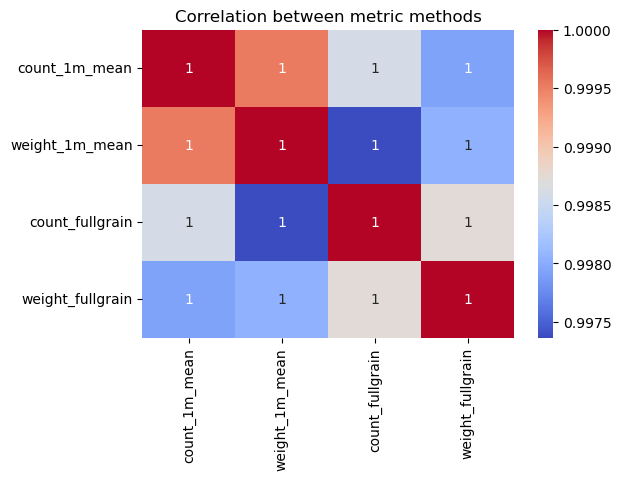

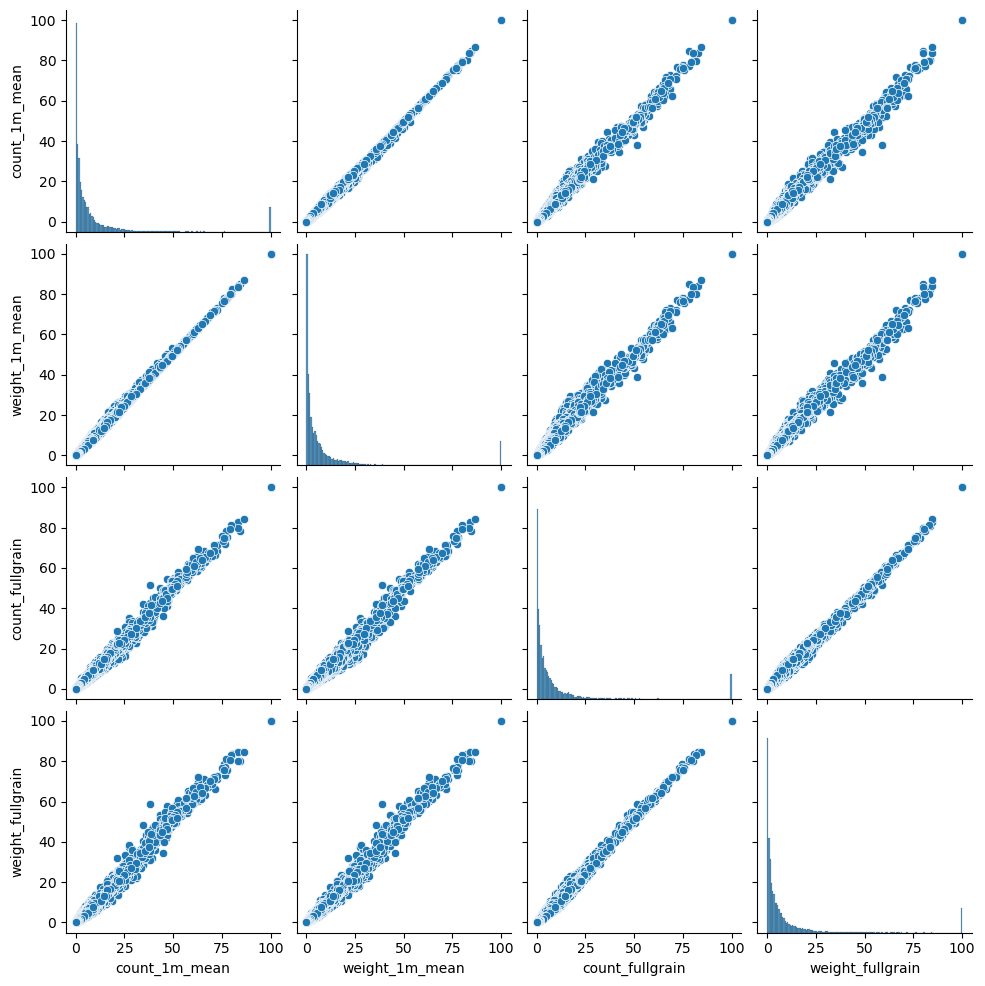

In [80]:
# Compare similarity between metric methods
metric_cols = ['count_1m_mean', 'weight_1m_mean', 'count_fullgrain', 'weight_fullgrain']

# Correlation matrix
corr = lcapture_metrics[metric_cols].corr()
display(corr)

# Absolute Mean Error (MAE) matrix
mae_matrix = pd.DataFrame(index=metric_cols, columns=metric_cols)
for col1 in metric_cols:
    for col2 in metric_cols:
        if col1 == col2:
            mae_matrix.loc[col1, col2] = 0.0
        else:
            mae = np.mean(np.abs(lcapture_metrics[col1] - lcapture_metrics[col2]))
            mae_matrix.loc[col1, col2] = mae
mae_matrix = mae_matrix.astype(float)

print(mean_absolute_error(lcapture_metrics['count_1m_mean'], lcapture_metrics['weight_1m_mean']))

# Optionally, visualize correlation matrix as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation between metric methods')
plt.show()

# Optionally, visualize pairwise relationships
sns.pairplot(lcapture_metrics[metric_cols])
plt.show()

In [98]:
def get_pad_methods(plot_id: str):
    ds = read_metric_ds(plot_id)
    pad_1m_mean = (
        (1 - ds["vox_lcapture"])
        .pipe(lambda da: xr.apply_ufunc(xr.ufuncs.log, da))
        .pipe(lambda da: da.where(~np.isneginf(da)))
        .mean(dim=["x", "y"])
    )
    pad_1m_mean_weight = (
        (1 - ds["vox_lcapture_weight"])
        .pipe(lambda da: xr.apply_ufunc(xr.ufuncs.log, da))
        .pipe(lambda da: da.where(~np.isneginf(da)))
        .mean(dim=["x", "y"])
    )

    pad_1m_fullgrain = (
        1
        - (
            ds["vox_inside_count"].sum(dim=["x", "y"])
            / ds["vox_enter_count"].sum(dim=["x", "y"])
        )
    ).pipe(lambda da: xr.apply_ufunc(xr.ufuncs.log, da))
    pad_1m_fullgrain_weight = (
        1
        - (
            ds["vox_inside_weight"].sum(dim=["x", "y"])
            / ds["vox_enter_weight"].sum(dim=["x", "y"])
        )
    ).pipe(lambda da: xr.apply_ufunc(xr.ufuncs.log, da))

    ds = xr.Dataset(
        {
            "pad_1m_mean": pad_1m_mean,
            "pad_1m_mean_weight": pad_1m_mean_weight,
            "pad_1m_fullgrain": pad_1m_fullgrain,
            "pad_1m_fullgrain_weight": pad_1m_fullgrain_weight,
        }
    )

    # # Remove ground level (z=0)
    # ds = ds.sel(z=slice(1, None))

    df = ds.to_dataframe().reset_index()

    # # Drop any rows with -inf values
    df = df.replace(-np.inf, np.nan).dropna()

    return df

In [99]:
get_pad_methods("AGG_O_01_P1")

/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return func(*args)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return func(*args)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return func(*args)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return func(*args)


,z,pad_1m_mean,pad_1m_mean_weight,pad_1m_fullgrain,pad_1m_fullgrain_weight
1,1.0,-0.768996,-0.791326,-0.607931,-0.602074
2,2.0,-0.074432,-0.065284,-0.064883,-0.051014
3,3.0,-0.055861,-0.045101,-0.057574,-0.042595
4,4.0,-0.062460,-0.050449,-0.067922,-0.051271
5,5.0,-0.077550,-0.064953,-0.083892,-0.065013
6,6.0,-0.099702,-0.088985,-0.105721,-0.086477
7,7.0,-0.121960,-0.115926,-0.124720,-0.109040
8,8.0,-0.124350,-0.127774,-0.122265,-0.116174
9,9.0,-0.119032,-0.132245,-0.112158,-0.114852
10,10.0,-0.096925,-0.116457,-0.090703,-0.101587


In [100]:
pad_results = []

for idx, row in plots.iterrows():
    df = get_pad_methods(idx)
    df['plot_id'] = idx
    pad_results.append(df)

pad_metrics = pd.concat(pad_results)
pad_metrics

/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return func(*args)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return func(*args)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return func(*args)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return func(*args)
/Users/jgregory/Code/forest-structure-tools/.pixi/envs/default/lib/python3.13/site-packages/xarray/computation/apply_ufunc.py:891: RuntimeWarning: divide by zero encountered in log
  return fu

,z,pad_1m_mean,pad_1m_mean_weight,pad_1m_fullgrain,pad_1m_fullgrain_weight,plot_id
1,1.0,-0.768996,-0.791326,-0.607931,-0.602074,AGG_O_01_P1
2,2.0,-0.074432,-0.065284,-0.064883,-0.051014,AGG_O_01_P1
3,3.0,-0.055861,-0.045101,-0.057574,-0.042595,AGG_O_01_P1
4,4.0,-0.062460,-0.050449,-0.067922,-0.051271,AGG_O_01_P1
5,5.0,-0.077550,-0.064953,-0.083892,-0.065013,AGG_O_01_P1
...,...,...,...,...,...,...
32,32.0,-0.000855,-0.000523,-0.001089,-0.000640,ULY_Y_96_P5
33,33.0,-0.000497,-0.000294,-0.000700,-0.000423,ULY_Y_96_P5
34,34.0,-0.000134,-0.000087,-0.000300,-0.000201,ULY_Y_96_P5
35,35.0,-0.000102,-0.000056,-0.000162,-0.000082,ULY_Y_96_P5


,pad_1m_mean,pad_1m_mean_weight,pad_1m_fullgrain,pad_1m_fullgrain_weight
pad_1m_mean,1.000000,0.998102,0.980702,0.978325
pad_1m_mean_weight,0.998102,1.000000,0.974736,0.976363
pad_1m_fullgrain,0.980702,0.974736,1.000000,0.996632
pad_1m_fullgrain_weight,0.978325,0.976363,0.996632,1.000000


,pad_1m_mean,pad_1m_mean_weight,pad_1m_fullgrain,pad_1m_fullgrain_weight
pad_1m_mean,0.000000,0.006296,0.011112,0.011868
pad_1m_mean_weight,0.006296,0.000000,0.016060,0.014100
pad_1m_fullgrain,0.011112,0.016060,0.000000,0.006897
pad_1m_fullgrain_weight,0.011868,0.014100,0.006897,0.000000


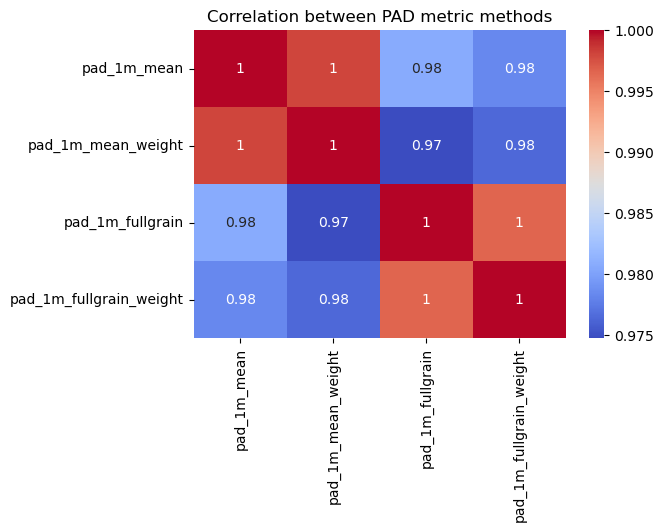

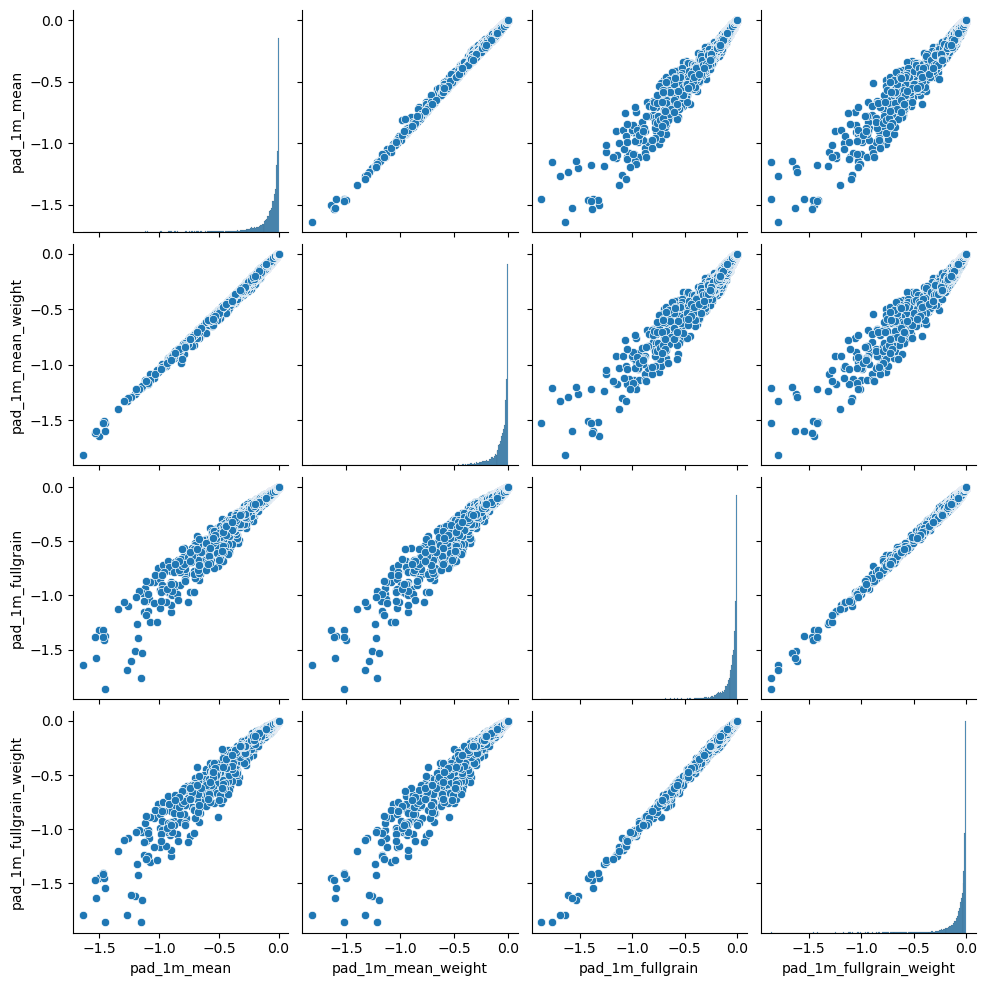

In [101]:
# Compare similarity between PAD metric methods
pad_cols = ['pad_1m_mean', 'pad_1m_mean_weight', 'pad_1m_fullgrain', 'pad_1m_fullgrain_weight']

# Correlation matrix
pad_corr = pad_metrics[pad_cols].corr()
display(pad_corr)

# Absolute Mean Error (MAE) matrix using sklearn
pad_mae_matrix = pd.DataFrame(index=pad_cols, columns=pad_cols)
for col1 in pad_cols:
    for col2 in pad_cols:
        if col1 == col2:
            pad_mae_matrix.loc[col1, col2] = 0.0
        else:
            mae = mean_absolute_error(pad_metrics[col1], pad_metrics[col2])
            pad_mae_matrix.loc[col1, col2] = mae
pad_mae_matrix = pad_mae_matrix.astype(float)
display(pad_mae_matrix)

# Optionally, visualize correlation matrix as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(6,4))
sns.heatmap(pad_corr, annot=True, cmap='coolwarm')
plt.title('Correlation between PAD metric methods')
plt.show()

# Optionally, visualize pairwise relationships
sns.pairplot(pad_metrics[pad_cols])
plt.show()